In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm

import cmocean.cm as cmo
import cmocean
import textwrap
import metpy.calc as mpcalc
from metpy.units import units
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds, select_months_df
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap
import composite_funcs as cfunc


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# import configuration file for case study choice
yaml_doc = '../data/domains.yml'
d = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

In [4]:
##################################
### LOAD HORIZONTAL COMPOSITES ###
##################################
## iterate through options
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
varname_lst = ['700z', 'ivt']
# ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]
ds_lst3 = []
ds_lst4 = []
for h, region in enumerate(region_lst):  
    tmp_lst = []
    tmp_lst2 = []
    for i, varname in enumerate(varname_lst):  
        ds_lst = []
        ds_lst2 = []
        for j, ssn in enumerate(ssn_lst):
            ## load anomaly composite data
            path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
            fname1 = path + '{0}/{2}/filtered_anomaly_composite_{0}_{1}.nc'.format(varname, ssn, region)
            fname2 = path + '{0}/{2}/filtered_anomaly_composite_tvals_{0}_{1}.nc'.format(varname, ssn, region)
        
            ds = xr.open_dataset(fname1)
            ds = ds.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
            ds_lst.append(ds)
    
            ds2 = xr.open_dataset(fname2)
            ds2 = ds2.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
            ds_lst2.append(ds2)
    
        ## concat ds_lst along ssn
        tmp = xr.concat(ds_lst, pd.Index(ssn_lst, name="ssn"))
        tmp_lst.append(tmp)
    
        tmp2 = xr.concat(ds_lst2, pd.Index(ssn_lst, name="ssn"))
        tmp_lst2.append(tmp2)
    
    ## merge two datasets
    ds3 = xr.merge(tmp_lst)
    ds_lst3.append(ds3)

    ## merge tvalue anomaly datasets
    ds4 = xr.merge(tmp_lst2)
    ds_lst4.append(ds4)

ds_hc = xr.concat(ds_lst3, pd.Index(region_lst, name="region"))
ds_tval = xr.concat(ds_lst4, pd.Index(region_lst, name="region"))
ds_hc

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, region: 3, ssn: 2)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * ssn        (ssn) object 'NDJFMA' 'MJJASO'
  * region     (region) object 'baja' 'san_juan' 'gulf_of_mexico'
Data variables:
    z          (region, ssn, latitude, longitude) float64 273.8 259.6 ... -3.372
    ivtv       (region, ssn, latitude, longitude) float64 -79.99 ... 3.562
    ivtu       (region, ssn, latitude, longitude) float64 -9.814 ... -32.09
    ivt        (region, ssn, latitude, longitude) float64 -37.2 -37.34 ... 18.32

In [5]:
ds_tval

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, region: 3, ssn: 2)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * ssn        (ssn) object 'NDJFMA' 'MJJASO'
  * region     (region) object 'baja' 'san_juan' 'gulf_of_mexico'
Data variables:
    z          (region, ssn, latitude, longitude) bool True True ... False False
    ivtv       (region, ssn, latitude, longitude) bool True True ... False False
    ivtu       (region, ssn, latitude, longitude) bool False False ... True True
    ivt        (region, ssn, latitude, longitude) bool True True ... True True

In [6]:
################################
### LOAD VERTICAL COMPOSITES ###
################################
## iterate through options
varname = 'uvwq'
region_lst = ['baja', 'baja2', 'san_juan2', 'san_juan', 'gulf_of_mexico', 'gulf_of_mexico2']
# ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]

ds_lst = []
ds_lst2 = []
ds_lst3 = []
df_lst = []
for i, region in enumerate(region_lst):  
    tmp_lst = []
    tmp_lst2 = []
    tmp_lst3 = []

    ## load dataframe for trajectory frequency
    fname = '../out/line_dates_{0}_full.csv'.format(region)
    df = pd.read_csv(fname)
    df = df.set_index(pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S'))
    df_lst.append(df)
    for j, ssn in enumerate(ssn_lst):
        ## load anomaly vertical composite data (uvwq)
        path = '/home/dnash/DATA/preprocessed/ERA5_composites/cross_section/'
        fname = path + 'filtered_anomaly_composite_{0}_{1}_{2}.nc'.format(varname, ssn, region)
        ds = xr.open_dataset(fname)
        tmp_lst.append(ds)

        ## load anomaly tval results
        fname = path + 'filtered_anomaly_composite_tvals_{0}_{1}_{2}.nc'.format(varname, ssn, region)
        ds = xr.open_dataset(fname)
        tmp_lst2.append(ds)
        
        ## load non-anomaly vertical composite data (sp and freezing level)
        fname = path + 'composite_{0}_{1}_{2}.nc'.format('sp_deg0l', ssn, region)
        ds = xr.open_dataset(fname)
        tmp_lst3.append(ds)

    ## concat tmp_lst along ssn (uvwq)
    tmp = xr.concat(tmp_lst, pd.Index(ssn_lst, name="ssn"))
    tmp2 = xr.concat(tmp_lst2, pd.Index(ssn_lst, name="ssn"))
    tmp3 = xr.concat(tmp_lst3, pd.Index(ssn_lst, name="ssn"))
    
    if (region == 'san_juan') | (region == 'san_juan2'):
        tmp = tmp.isel(location=slice(0, -12))
        tmp2 = tmp2.isel(location=slice(0, -12))
        tmp3 = tmp3.isel(location=slice(0, -12))
    ds_lst.append(tmp)
    ds_lst2.append(tmp2)
    ds_lst3.append(tmp3)



In [7]:
def plot_horizontal_composite(fig, ax, ds, tval, cbax):    
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    cmap = cm.BrBG
    cflevs = np.arange(-100., 110., 10)
    # cbarticks = bnds[::2]
    norm = mcolors.BoundaryNorm(cflevs, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, norm=norm, cmap=cmap, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec_mask = ds.ivtu.where((tval.ivtu == True) | (tval.ivtv == True)).values
    vvec_mask = ds.ivtv.where((tval.ivtu == True) | (tval.ivtv == True)).values

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(-20, 22, 2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
        txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

    # quiver key
    qk = ax.quiverkey(Q, 0.75, 1.05, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 6.0})
    
    # Colorbar (single)
    cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
    cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
    cb.ax.tick_params(labelsize=12)

    return ax

-5.539005932443324 2.6951674417956197
-5.109265229950392 2.595006913720653
-2.63841162926333 2.923553717107853
-0.0019957169461890254 0.028087376918215015
-0.018775805888570012 0.009970357676742822
-0.06022689278157015 0.00929457792093565
-0.1097318038943918 0.007262255249414453
-0.1412127480533195 0.0021607584575580392
-0.2204080454537006 -0.04779582044582611


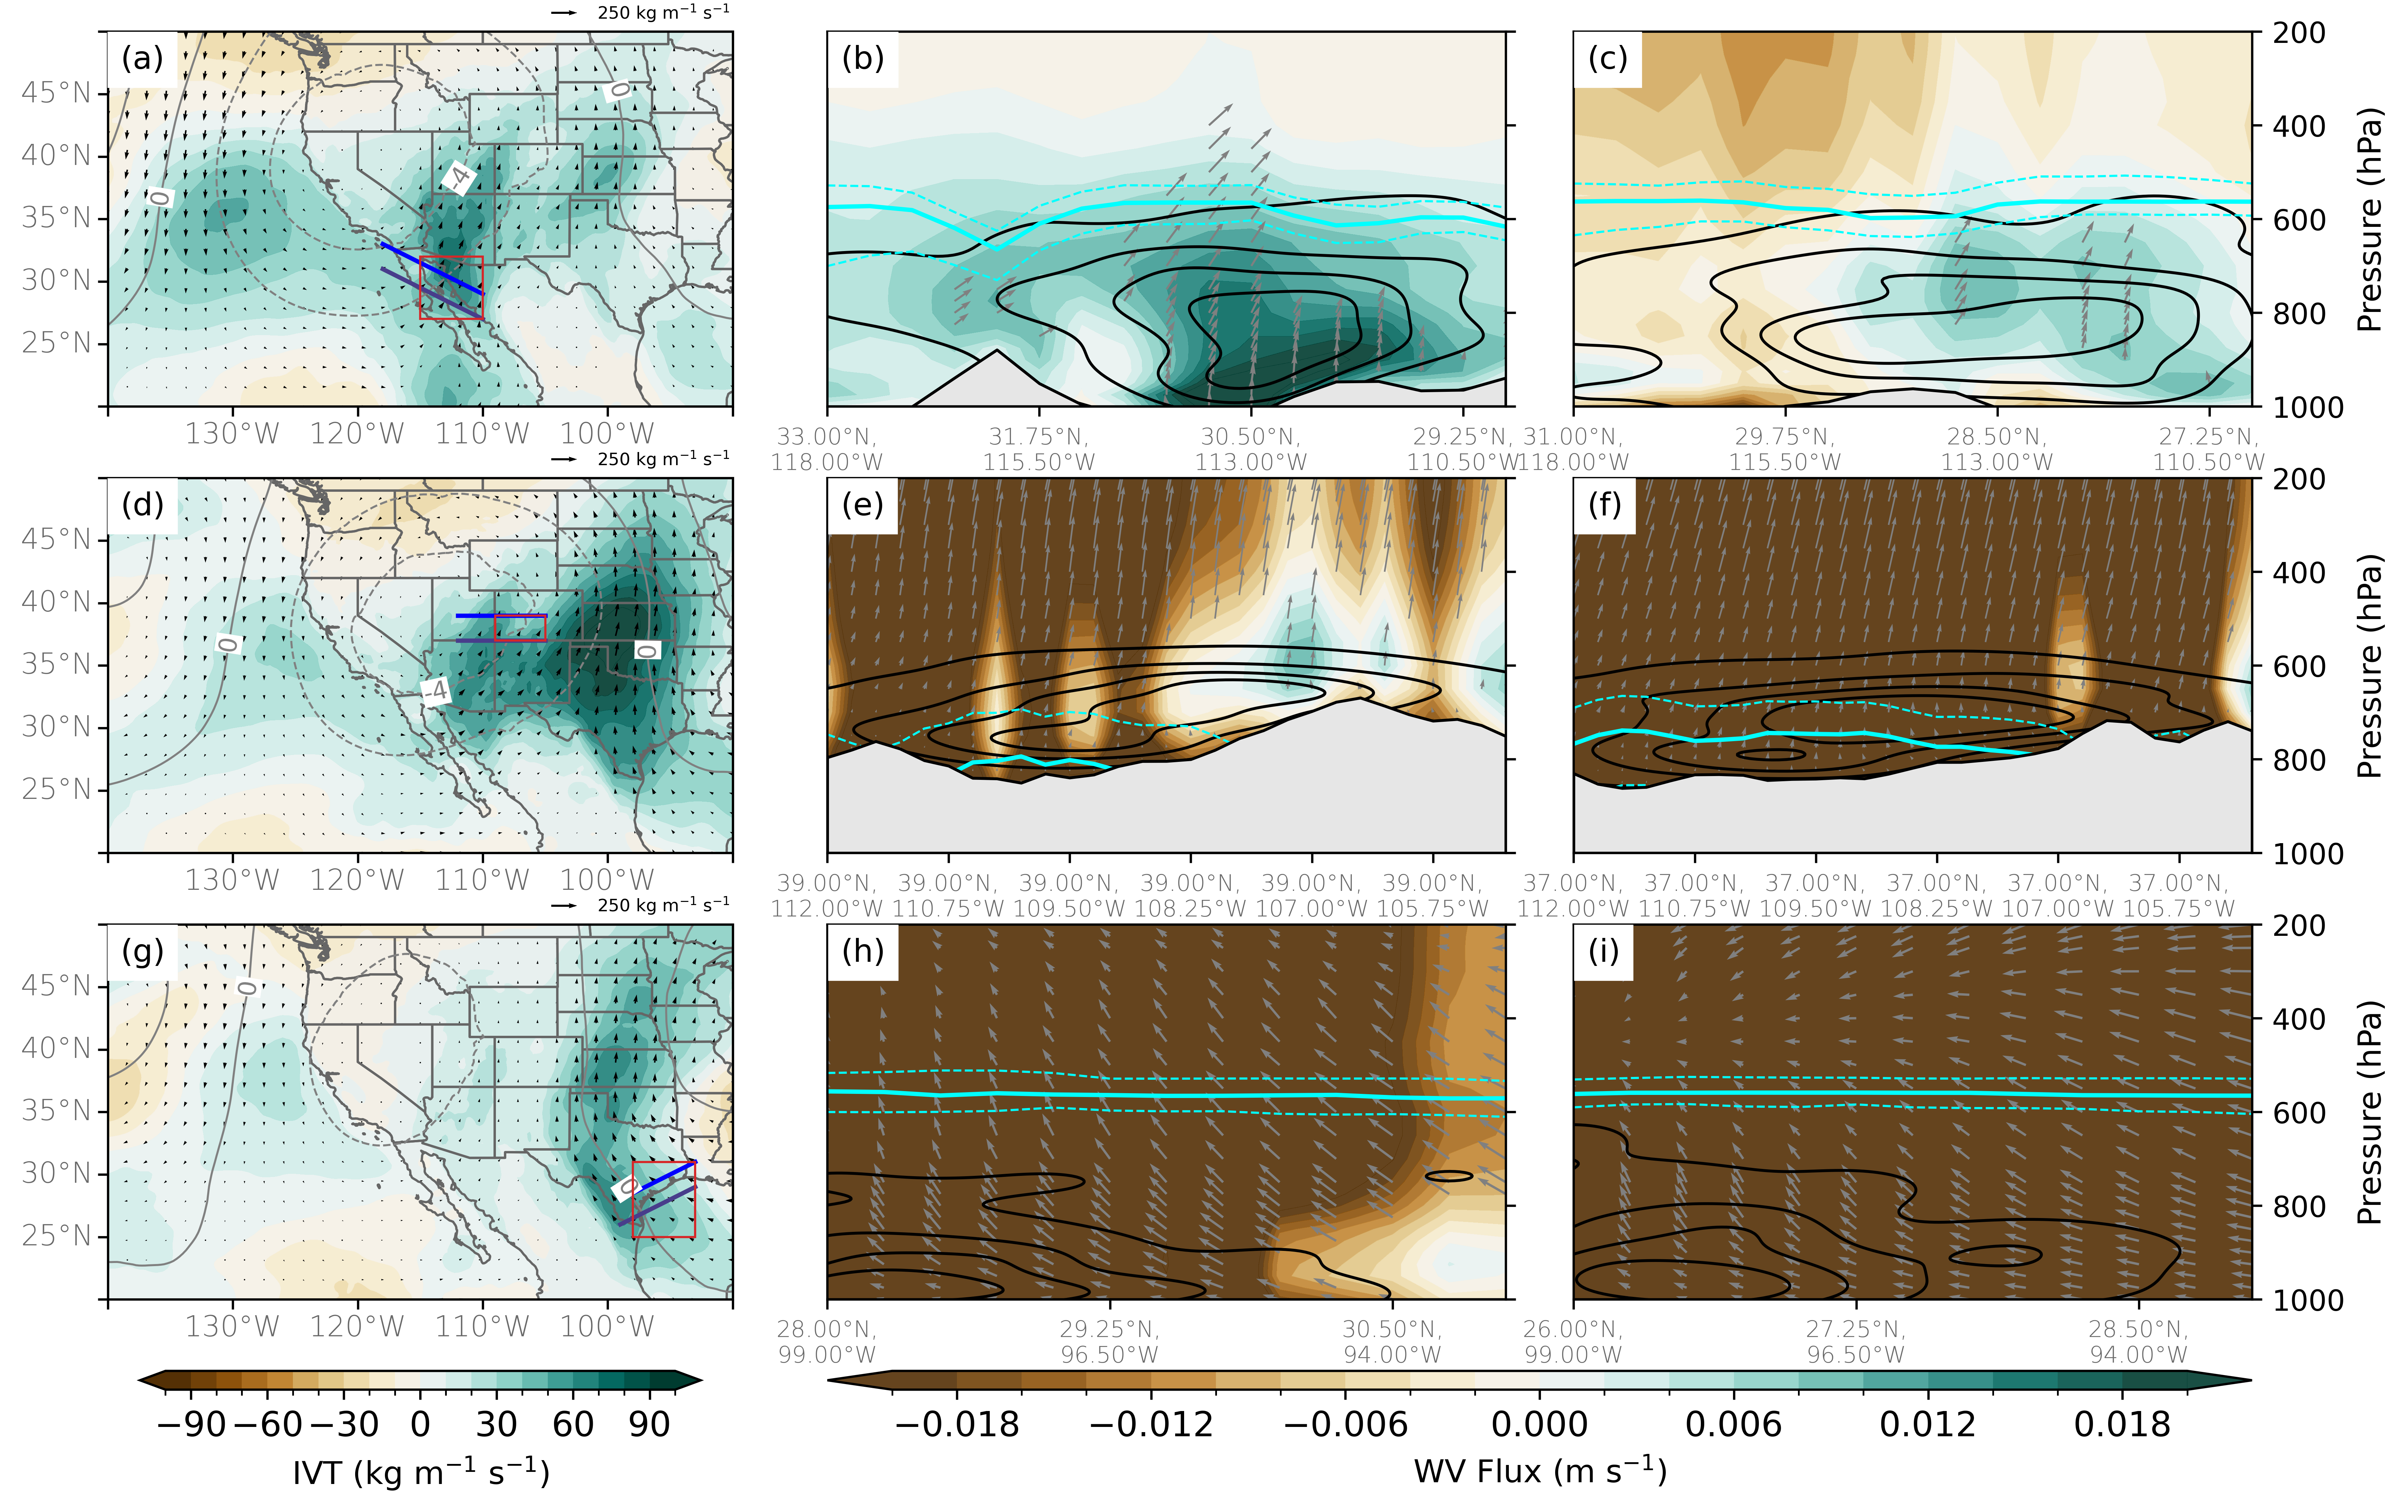

In [11]:
nrows = 4
ncols = 3
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05], width_ratios = [1, 1, 1], wspace=0.1, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(13.5, 8.5))
fig.dpi = 600
ssn = 'MJJASO' ## 'NDJFMA' or 'MJJASO'
fname = path_to_figs + '{0}_anomaly_composite_trajectory'.format(ssn)
fmt = 'png'

############################
### HORIZONTAL COMPOSITE ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
ext = [-140., -90., 20, 50]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

cbax = fig.add_subplot(gs[-1,0]) # colorbar axis
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
letter_lst = ['a', 'd', 'g']
for i, region in enumerate(region_lst):
    ds3 = ds_hc.sel(ssn=ssn, region=region)
    tval = ds_tval.sel(ssn=ssn, region=region)
    ax = fig.add_subplot(gs[i, 0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    ax = plot_horizontal_composite(fig, ax, ds3, tval, cbax)
    
    ## add extent of bbox
    ext3 = d[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='tab:red',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
    clst = ['blue', 'darkslateblue']
    line_lst = [region, region+'2']
    for j, line in enumerate(line_lst):
        ## add cross section line
        ax.plot([d[line]['start_pt'][1], d[line]['end_pt'][1]],
                [d[line]['start_pt'][0], d[line]['end_pt'][0]], color=clst[j],
                transform=ccrs.PlateCarree(), zorder=3)

    titlestring = '({0})'.format(letter_lst[i])
    ax.text(0.02, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


##############################
### VERTICAL CROSS SECTION ###
##############################
## y-axis is pressure
## x-axis are the points
row_idx = [0, 0, 1, 1, 2, 2]
col_idx = [1, 2, 1, 2, 1, 2]
letter_lst = ['b', 'c', 'e', 'f', 'h', 'i']
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
    ds1 = ds_lst[i].sel(ssn=ssn)
    ds2 = ds_lst2[i].sel(ssn=ssn)
    ds3 = ds_lst3[i].sel(ssn=ssn)
    ax = fig.add_subplot(gs[row, col])
    # xs = np.arange(0, len(ds.location), 1) # how many coordinate values
    xs = ds1.longitude.values # latitude / x-axis coords
    ys = ds1.level.values
    terline = ds3.sp.sel(quantile=.5).values / 100
    ht_fill = ax.fill_between(xs, 1000, terline, facecolor='0.9', edgecolor='k', zorder=10)
    
    # Filled contours (WV flux)
    cmap = cm.BrBG
    cflevs = np.arange(-0.02, 0.022, 0.002)
    norm = mcolors.BoundaryNorm(cflevs, cmap.N)
    data = ds1.wvflux
    print(data.values.min(), data.values.max())
    cf = ax.contourf(xs, ys, data, levels=cflevs, norm=norm, cmap=cmap, alpha=0.9, extend='both', zorder=-1)

    # Wind barbs / vectors
    uvec_mask = ds1.u.where((ds2.wvflux == True)).values
    vvec_mask = ds1.v.where((ds2.wvflux == True)).values

    Q = ax.quiver(xs, ys, uvec_mask, vvec_mask, 
                  color='grey')
    
    ## labels
    plt.gca().invert_yaxis()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim(1000, 200)
    ax.set_xlim(xs.max(), xs.min())
    if col == 2:
        ax.set_ylabel("Pressure (hPa)", fontsize=11)
    elif col == 1:
        ax.tick_params(labelright=False)
    
    # ## add trajectory point kde
    ## subset dataframe to current season
    start_mon, end_mon = cfunc.get_startmon_and_endmon(ssn)
    df_tmp = select_months_df(df_lst[i], start_mon, end_mon)
    x = df_tmp.lon.values
    y = df_tmp.level.values
    sns.kdeplot(x=x, y=y, levels=5, color="k", linewidths=1)
    
    ## add freezing level
    freeze_line50 = ax.plot(xs, ds3.deg0l.sel(quantile=0.5), c='cyan', lw=1.5)
    freeze_line90 = ax.plot(xs, ds3.deg0l.sel(quantile=0.9), c='cyan', lw=0.75, linestyle='dashed')
    freeze_line10 = ax.plot(xs, ds3.deg0l.sel(quantile=0.1), c='cyan', lw=0.75, linestyle='dashed')
    
    x_ticks = np.arange(len(xs))
    x_labels = [u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(ds1.latitude.values[i], ds1.longitude.values[i]*-1) for i in x_ticks]
    # set the frequency of xtick labels
    skip = 5
    xtick_lbls = [textwrap.fill(label, 8) for label in x_labels[0::skip]]
    ax.set_xticks(xs[0::skip], xtick_lbls, fontsize=6, **kw_ticklabels)

    plt.gca().invert_xaxis()

    titlestring = '({0})'.format(letter_lst[i])
    ax.text(0.02, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

# Add color bar
# cbarticks = norm[::1]
cbax = plt.subplot(gs[-1,1:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('WV Flux (m s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()